In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image
import os
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/leaves/testing")
!pwd
print(device)

/teamspace/studios/this_studio/ML-Assignment-4
cuda


In [3]:
def load_image(url, angle=0): 
    image = Image.open(url).rotate(angle)
    image = np.array(image)
    image = image / 255
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float()
    return image

def load_train_data(batch_size=4, angles = [0], seed=42):
    train_x = [load_image(f'Resized_Dataset/train/{i}', ang) for ang in angles for i in os.listdir("Resized_Dataset/train")]
    train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for _ in range(len(angles)) for i in os.listdir("Resized_Dataset/train")]
    train_x = torch.stack(train_x)
    train_y = torch.tensor(train_y)
    train_data = TensorDataset(train_x, train_y)
    torch.manual_seed(seed)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    return train_loader

def load_test_data(batch_size=40):
    test_x = [load_image(f'Resized_Dataset/test/{i}') for i in os.listdir("Resized_Dataset/test")]
    test_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset/test")]
    test_x = torch.stack(test_x)
    test_y = torch.tensor(test_y)
    test_data = TensorDataset(test_x, test_y)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return test_loader


def accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float().flatten()
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += (labels.size(0))*nn.BCEWithLogitsLoss()(outputs.flatten(), labels.float()).item()
    return correct / total, loss/total

def train(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001, every=5):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_step = len(train_loader)
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.flatten(), labels.float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # test_acc, test_loss = accuracy(model, test_loader)
            # train_acc, train_loss = accuracy(model, train_loader)
            # writer.add_scalar('Loss/train', train_loss, epoch*total_step + i)
            # writer.add_scalar('Loss/test', test_loss, epoch*total_step + i)
            # writer.add_scalar('Accuracy/train', train_acc, epoch*total_step + i)
            # writer.add_scalar('Accuracy/test', test_acc, epoch*total_step + i)

            if (i + 1) % every == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        test_acc, test_loss = accuracy(model, test_loader)
        train_acc, train_loss = accuracy(model, train_loader)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('Train Accuracy: {}, Test Accuracy: {}'.format(train_acc_list[-1], test_acc_list[-1]))
    return (train_loss_list, test_loss_list, train_acc_list, test_acc_list)



def view_misclassified(model, transfo=transforms.Compose([])): 
    # Viewing all misclassified images at once   
    test_paths = os.listdir("Resized_Dataset/test")
    fig = plt.figure(figsize=(20, 20))
    wrong_predictions = []
    predicted_labels = []
    actual_labels = []
    output_values = []
    model.eval()
    for path in test_paths:
        image = transfo(load_image(f'Resized_Dataset/test/{path}')).unsqueeze(0).to(device)
        label = 0 if (path.split('_')[1])=="healthy.jpg" else 1
        output = model(image)
        predicted = (torch.sigmoid(output) > 0.5).float().item()
        if predicted != label:
            #print(f"Predicted: {int(predicted)}, output: {round((torch.sigmoid(output)).item(), 2)} Actual: {label}")
            wrong_predictions.append(path)
            predicted_labels.append(predicted)
            actual_labels.append(label)
            output_values.append(round((torch.sigmoid(output)).item(), 2))
            #print(path)
            #display(Image.open(f'Resized_Dataset/test/{path}'))
            #print("")
    for i, path in enumerate(wrong_predictions):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(Image.open(f'Resized_Dataset/test/{path}'))
        plt.title(f"Predicted: {predicted_labels[i]}, output: {output_values[i]} Actual: {actual_labels[i]}")
    plt.show()



In [4]:
# Making Dataloaders
train_loader = load_train_data(batch_size=16, angles=[0])
test_loader = load_test_data(batch_size=40)

In [5]:
# Defining models
class VGG1(nn.Module):
    def __init__(self):
        super(VGG1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*112*112, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.params = (sum(p.numel() for p in self.parameters()))
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG2(nn.Module):
    def __init__(self):
        super(VGG2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*56*56, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG3(nn.Module):
    def __init__(self):
        super(VGG3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            #nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 15, kernel_size=3, padding=1),
            #nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(15, 20, kernel_size=3, padding=1),
            #nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(20*28*28, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        out = self.conv(x)
        out = self.mlp(out)
        return out
    
class VGG4(nn.Module):
    def __init__(self):
        super(VGG4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(10, 10, kernel_size=3, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(10*14*14, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out
    
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # MLP layer
        self.layer2 = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),

            nn.Linear(4096, 1000),
            nn.ReLU(),

            nn.Linear(1000, num_classes)
        )
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out

In [6]:
vgg1 = VGG1().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg1, train_loader, test_loader, num_epochs=20, learning_rate=0.001)

Epoch [1/20], Step [5/10], Loss: 0.7106
Epoch [1/20], Step [10/10], Loss: 0.7066
Train Accuracy: 0.55, Test Accuracy: 0.55
Epoch [2/20], Step [5/10], Loss: 0.6995
Epoch [2/20], Step [10/10], Loss: 0.6570
Train Accuracy: 0.70625, Test Accuracy: 0.7
Epoch [3/20], Step [5/10], Loss: 0.7282
Epoch [3/20], Step [10/10], Loss: 0.6449
Train Accuracy: 0.70625, Test Accuracy: 0.7
Epoch [4/20], Step [5/10], Loss: 0.5516
Epoch [4/20], Step [10/10], Loss: 0.5937
Train Accuracy: 0.7125, Test Accuracy: 0.6
Epoch [5/20], Step [5/10], Loss: 0.6403
Epoch [5/20], Step [10/10], Loss: 0.5949
Train Accuracy: 0.71875, Test Accuracy: 0.825
Epoch [6/20], Step [5/10], Loss: 0.4436
Epoch [6/20], Step [10/10], Loss: 0.5260
Train Accuracy: 0.6875, Test Accuracy: 0.725
Epoch [7/20], Step [5/10], Loss: 0.8503
Epoch [7/20], Step [10/10], Loss: 0.8165
Train Accuracy: 0.78125, Test Accuracy: 0.8
Epoch [8/20], Step [5/10], Loss: 0.3928
Epoch [8/20], Step [10/10], Loss: 0.5531
Train Accuracy: 0.775, Test Accuracy: 0.775


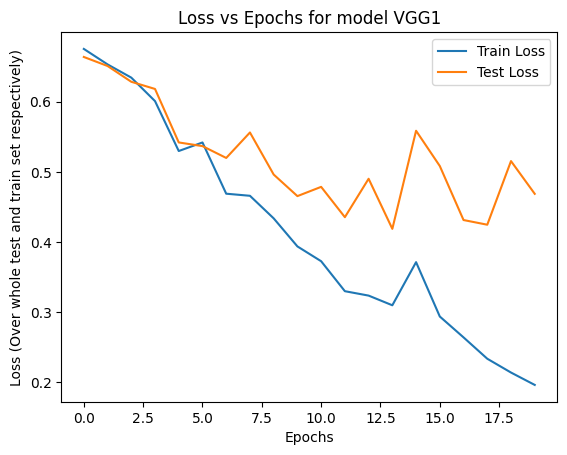

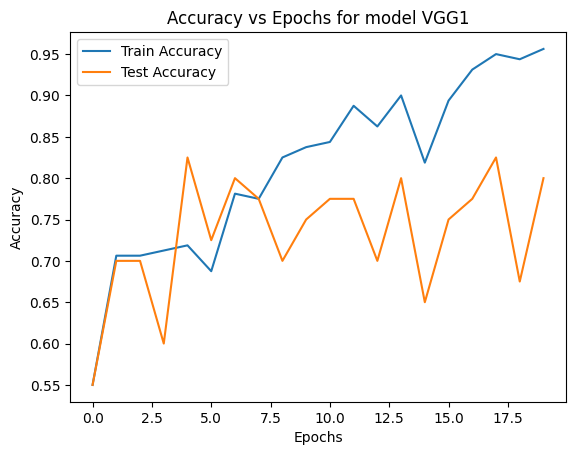

In [7]:
plt.title("Loss vs Epochs for model {}".format(vgg1.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg1.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

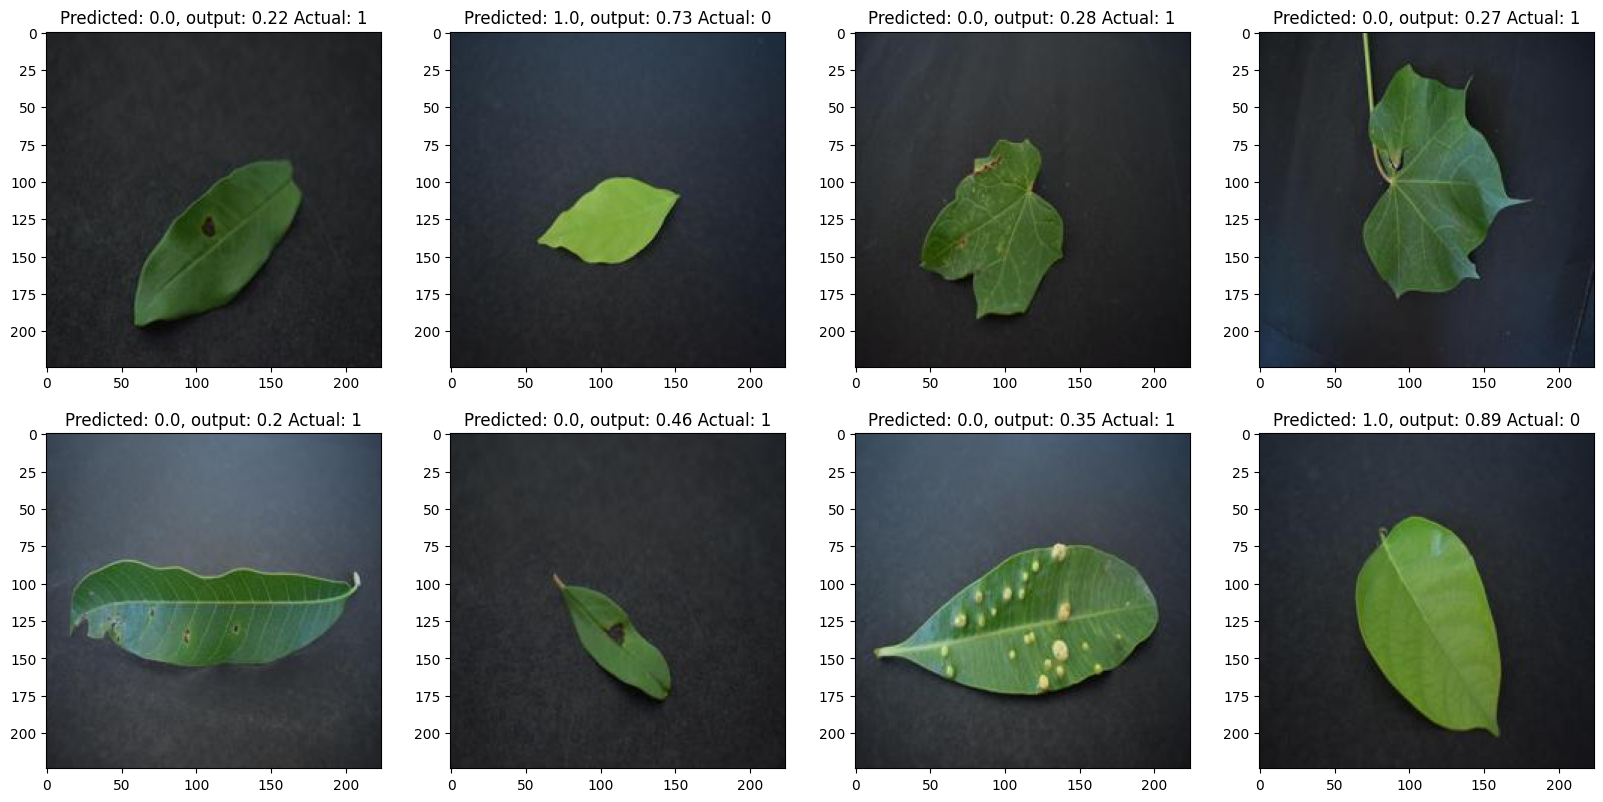

In [8]:
view_misclassified(vgg1)

In [9]:
vgg3 = VGG3().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg3, train_loader, test_loader, num_epochs=40, learning_rate=0.001, every=10)


Epoch [1/40], Step [10/10], Loss: 0.6906
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/40], Step [10/10], Loss: 0.7024
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [3/40], Step [10/10], Loss: 0.6897
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [4/40], Step [10/10], Loss: 0.6540
Train Accuracy: 0.56875, Test Accuracy: 0.575
Epoch [5/40], Step [10/10], Loss: 0.6712
Train Accuracy: 0.61875, Test Accuracy: 0.6
Epoch [6/40], Step [10/10], Loss: 0.6616
Train Accuracy: 0.5625, Test Accuracy: 0.55
Epoch [7/40], Step [10/10], Loss: 0.7475
Train Accuracy: 0.70625, Test Accuracy: 0.675
Epoch [8/40], Step [10/10], Loss: 0.6476
Train Accuracy: 0.6875, Test Accuracy: 0.7
Epoch [9/40], Step [10/10], Loss: 0.6936
Train Accuracy: 0.56875, Test Accuracy: 0.55
Epoch [10/40], Step [10/10], Loss: 0.6835
Train Accuracy: 0.71875, Test Accuracy: 0.675
Epoch [11/40], Step [10/10], Loss: 0.5750
Train Accuracy: 0.7375, Test Accuracy: 0.725
Epoch [12/40], Step [10/10], Loss: 0.5545
Train Accuracy: 0.74375, T

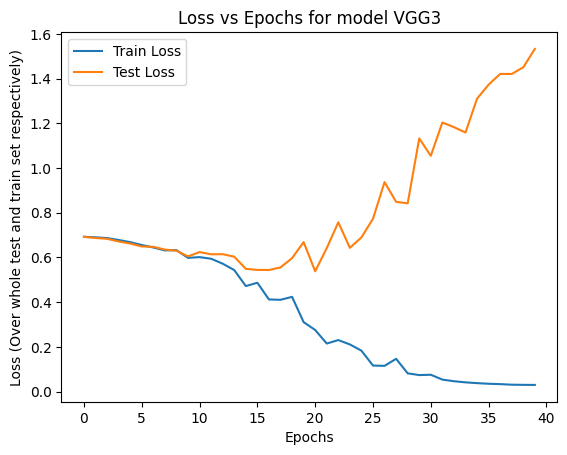

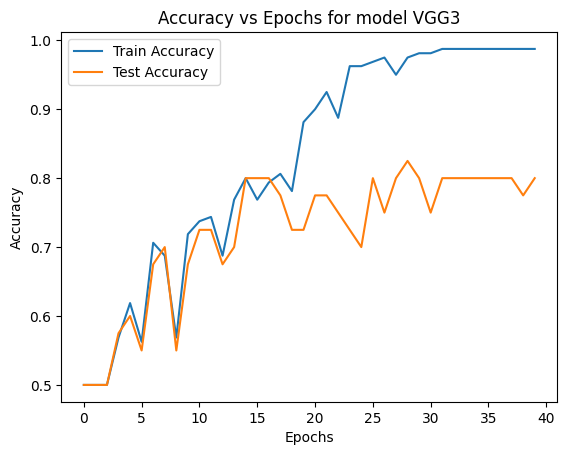

In [10]:
plt.title("Loss vs Epochs for model {}".format(vgg3.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg3.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:

aug_train_loader = load_train_data(batch_size=8, angles=[0, 90, 180, 270], seed=10)
vgg3_aug = VGG3().to(device)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg3_aug, aug_train_loader, test_loader, num_epochs=40, learning_rate=0.001, every=40)


Epoch [1/40], Step [40/80], Loss: 0.6981
Epoch [1/40], Step [80/80], Loss: 0.7080
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [2/40], Step [40/80], Loss: 0.7019
Epoch [2/40], Step [80/80], Loss: 0.6789
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [3/40], Step [40/80], Loss: 0.6760
Epoch [3/40], Step [80/80], Loss: 0.6909
Train Accuracy: 0.590625, Test Accuracy: 0.525
Epoch [4/40], Step [40/80], Loss: 0.6879
Epoch [4/40], Step [80/80], Loss: 0.6854
Train Accuracy: 0.6328125, Test Accuracy: 0.675
Epoch [5/40], Step [40/80], Loss: 0.4996
Epoch [5/40], Step [80/80], Loss: 0.5953
Train Accuracy: 0.571875, Test Accuracy: 0.5
Epoch [6/40], Step [40/80], Loss: 0.7644
Epoch [6/40], Step [80/80], Loss: 0.5643
Train Accuracy: 0.646875, Test Accuracy: 0.65
Epoch [7/40], Step [40/80], Loss: 0.8001
Epoch [7/40], Step [80/80], Loss: 0.7004
Train Accuracy: 0.6265625, Test Accuracy: 0.625
Epoch [8/40], Step [40/80], Loss: 0.5105
Epoch [8/40], Step [80/80], Loss: 0.5749
Train Accuracy: 0.6765625, Tes

Epoch [18/40], Step [80/80], Loss: 0.1253
Train Accuracy: 0.9921875, Test Accuracy: 0.775
Epoch [19/40], Step [40/80], Loss: 0.0213
Epoch [19/40], Step [80/80], Loss: 0.0562
Train Accuracy: 0.9796875, Test Accuracy: 0.725
Epoch [20/40], Step [40/80], Loss: 0.0146
Epoch [20/40], Step [80/80], Loss: 0.0240
Train Accuracy: 0.9921875, Test Accuracy: 0.775
Epoch [21/40], Step [40/80], Loss: 0.0019
Epoch [21/40], Step [80/80], Loss: 0.0176
Train Accuracy: 1.0, Test Accuracy: 0.75
Epoch [22/40], Step [40/80], Loss: 0.0685
Epoch [22/40], Step [80/80], Loss: 0.0411
Train Accuracy: 0.9984375, Test Accuracy: 0.75
Epoch [23/40], Step [40/80], Loss: 0.0030
Epoch [23/40], Step [80/80], Loss: 0.0019
Train Accuracy: 1.0, Test Accuracy: 0.725
Epoch [24/40], Step [40/80], Loss: 0.0034
Epoch [24/40], Step [80/80], Loss: 0.0259
Train Accuracy: 0.9890625, Test Accuracy: 0.8
Epoch [25/40], Step [40/80], Loss: 0.0143
Epoch [25/40], Step [80/80], Loss: 0.0184
Train Accuracy: 0.9984375, Test Accuracy: 0.725
Ep

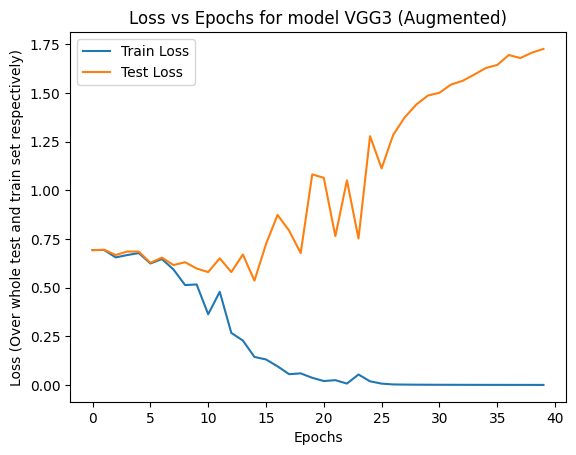

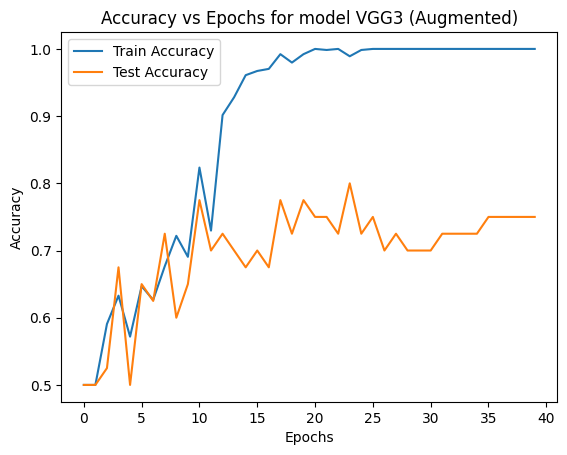

In [12]:
plt.title("Loss vs Epochs for model {} (Augmented)".format(vgg3_aug.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {} (Augmented)".format(vgg3_aug.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Define the preprocessing transformations
transform = transforms.Compose([
    #transforms.ToTensor(),                 # Convert the image to a PyTorch tensor (range 0 to 1)
    transforms.Normalize(                  # Normalize using ImageNet statistics
        mean=[0.485, 0.456, 0.406],        # Mean for ImageNet
        std=[0.229, 0.224, 0.225]          # Std for ImageNet
    ),
])

# Apply the transformations to the image
train_x = [transform(load_image(f'Resized_Dataset/train/{i}')) for i in os.listdir("Resized_Dataset/train")]
train_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset/train")]
train_x = torch.stack(train_x)
train_y = torch.tensor(train_y)
train_data = TensorDataset(train_x, train_y)
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

test_x = [transform(load_image(f'Resized_Dataset/test/{i}')) for i in os.listdir("Resized_Dataset/test")]
test_y = [(0 if (i.split('_')[1])=="healthy.jpg" else 1) for i in os.listdir("Resized_Dataset/test")]
test_x = torch.stack(test_x)
test_y = torch.tensor(test_y)
test_data = TensorDataset(test_x, test_y)
torch.manual_seed(42)
test_loader = DataLoader(test_data, batch_size=40, shuffle=False)

In [14]:
# Tuning all layers
vgg16 = models.vgg16(pretrained=True)
# Replacing the MLP layer of vgg16 with a lightweight new one with 1 output 
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)
vgg16 = vgg16.to(device)
#train_loader = load_train_data(batch_size=1, angles=[0], seed=42)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg16, train_loader, test_loader, num_epochs=40, learning_rate=1e-3, every=10)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40], Step [10/20], Loss: 0.7263
Epoch [1/40], Step [20/20], Loss: 0.6887
Train Accuracy: 0.5, Test Accuracy: 0.5


Epoch [2/40], Step [10/20], Loss: 0.6923
Epoch [2/40], Step [20/20], Loss: 0.7019
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [3/40], Step [10/20], Loss: 0.6976
Epoch [3/40], Step [20/20], Loss: 0.8084
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [4/40], Step [10/20], Loss: 0.6982
Epoch [4/40], Step [20/20], Loss: 0.6947
Train Accuracy: 0.4375, Test Accuracy: 0.475
Epoch [5/40], Step [10/20], Loss: 0.6851
Epoch [5/40], Step [20/20], Loss: 0.6935
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [6/40], Step [10/20], Loss: 0.6940
Epoch [6/40], Step [20/20], Loss: 0.6923
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [7/40], Step [10/20], Loss: 0.7279
Epoch [7/40], Step [20/20], Loss: 0.6934
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [8/40], Step [10/20], Loss: 0.6958
Epoch [8/40], Step [20/20], Loss: 0.6942
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [9/40], Step [10/20], Loss: 0.6925
Epoch [9/40], Step [20/20], Loss: 0.6928
Train Accuracy: 0.5, Test Accuracy: 0.5
Epoch [10/40], Step

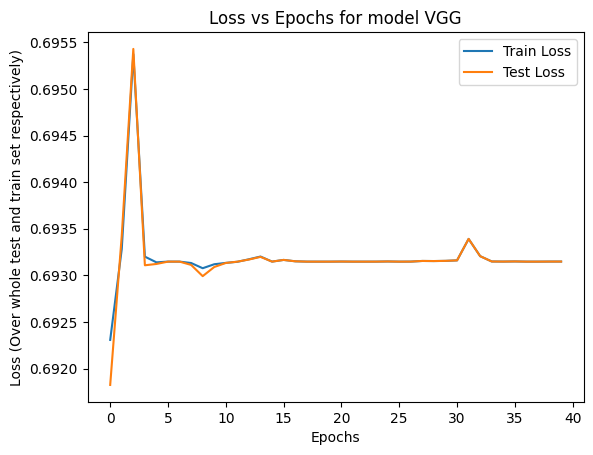

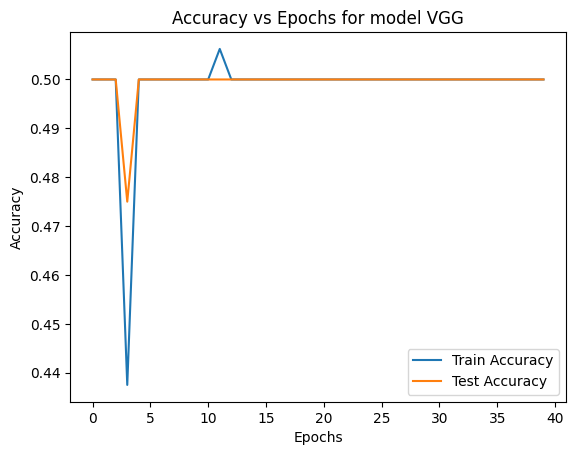

In [15]:
plt.title("Loss vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
# Tuning all layers
vgg16 = models.vgg16(pretrained=True)
# Replacing the MLP layer of vgg16 with a lightweight new one with 1 output 
for param in vgg16.parameters():
    param.requires_grad = False  # Freeze the convolutional layers


vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)
vgg16 = vgg16.to(device)
#train_loader = load_train_data(batch_size=1, angles=[0], seed=42)
train_loss_list, test_loss_list, train_acc_list, test_acc_list = train(vgg16, train_loader, test_loader, num_epochs=40, learning_rate=0.001, every=10)

Epoch [1/40], Step [10/20], Loss: 0.5509
Epoch [1/40], Step [20/20], Loss: 0.7265


Train Accuracy: 0.75, Test Accuracy: 0.85
Epoch [2/40], Step [10/20], Loss: 0.5887
Epoch [2/40], Step [20/20], Loss: 0.4293
Train Accuracy: 0.75, Test Accuracy: 0.75
Epoch [3/40], Step [10/20], Loss: 0.5979
Epoch [3/40], Step [20/20], Loss: 0.6357
Train Accuracy: 0.7875, Test Accuracy: 0.8
Epoch [4/40], Step [10/20], Loss: 0.6578
Epoch [4/40], Step [20/20], Loss: 0.5775
Train Accuracy: 0.8375, Test Accuracy: 0.925
Epoch [5/40], Step [10/20], Loss: 0.4381
Epoch [5/40], Step [20/20], Loss: 0.4932
Train Accuracy: 0.8875, Test Accuracy: 0.925
Epoch [6/40], Step [10/20], Loss: 0.4493
Epoch [6/40], Step [20/20], Loss: 0.3970
Train Accuracy: 0.8625, Test Accuracy: 0.925
Epoch [7/40], Step [10/20], Loss: 0.4252
Epoch [7/40], Step [20/20], Loss: 0.2676
Train Accuracy: 0.8125, Test Accuracy: 0.85
Epoch [8/40], Step [10/20], Loss: 0.4308
Epoch [8/40], Step [20/20], Loss: 0.2671
Train Accuracy: 0.925, Test Accuracy: 0.95
Epoch [9/40], Step [10/20], Loss: 0.5568
Epoch [9/40], Step [20/20], Loss: 0.

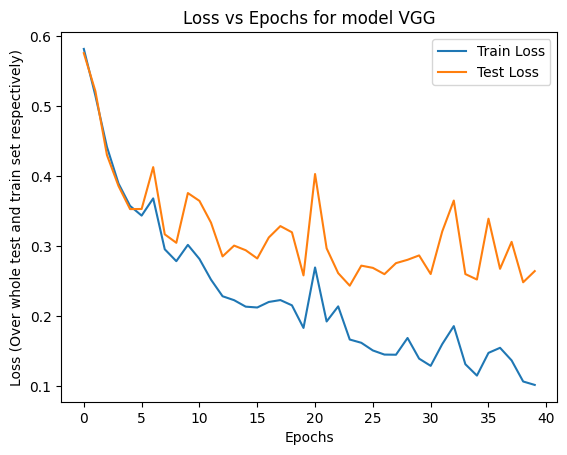

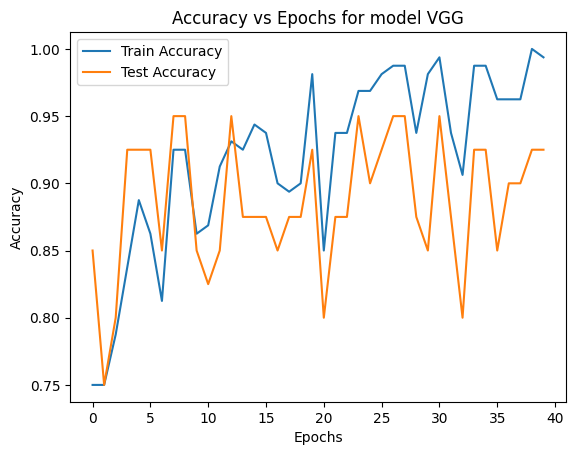

In [17]:
plt.title("Loss vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Over whole test and train set respectively)')
plt.legend()
plt.show()

plt.title("Accuracy vs Epochs for model {}".format(vgg16.__class__.__name__))
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

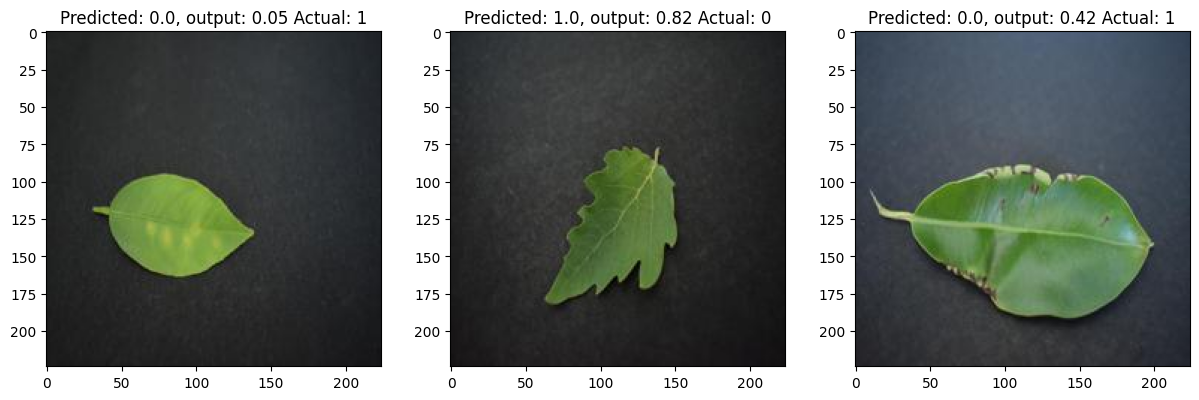

In [18]:
view_misclassified(vgg16, transform)